In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report
import numpy as np

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

/Users/sebastianapelgren/code/poop-ai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ─── SETUP ────────────

In [2]:
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

MODEL_NAME = "openai/clip-vit-base-patch32"

model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)

Using device: mps


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# ─── LOAD IMAGES ───────

In [3]:
def load_images_from_folder(folder):
    image_paths, labels = [], []
    for label_idx, class_name in enumerate(sorted(os.listdir(folder))):
        
        class_dir = Path(folder) / class_name

        print(f"Loading images from: {class_dir}")
        if not class_dir.is_dir():
            continue

        counter = 0
        for img_file in list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png")):
            image_paths.append(str(img_file))
            labels.append(label_idx)
            counter += 1
        print(f"Loaded {counter} images from {class_name}")
    return image_paths, labels

# ─── INFERENCE ──────────

In [4]:
def classify_clip(image_paths):
    predictions = []
    with torch.no_grad():
        for path in tqdm(image_paths, desc="Classifying images"):
            image = Image.open(path).convert("RGB")
            inputs = processor(text=CLASS_NAMES, images=image, return_tensors="pt", padding=True).to(DEVICE)
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image  # image-text similarity
            probs = logits_per_image.softmax(dim=1)
            pred = probs.argmax().item()
            predictions.append(pred)
    return predictions

# ─── MAIN EXECUTION ────

In [10]:
!find ../datasets/data-blood -name ".DS_Store" -type f -delete

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
CLASS_NAMES = [
   "red color stool with visible blood",
    "stool",
]



#CLASS_NAMES = [f"Bristol Stool Chart Type {c}" for c in [1,2,3,4,5,6,7]]

print(f"We have {len(CLASS_NAMES)} classes.")
for i, name in enumerate(CLASS_NAMES):
    print(f"{i}: {name}")


We have 2 classes.
0: red color stool with visible blood
1: stool


In [29]:
TEST_DIR = "../datasets/data-blood"  # <-- CHANGE TO YOUR TEST IMAGE DIR
image_paths, true_labels = load_images_from_folder(TEST_DIR)
preds = classify_clip(image_paths)

Loading images from: ../datasets/data-blood/blood
Loaded 18 images from blood
Loading images from: ../datasets/data-blood/no-blood
Loaded 139 images from no-blood


Classifying images: 100%|██████████| 157/157 [00:04<00:00, 32.61it/s]


# ─── EVALUATION ─────

In [30]:
print("\nClassification Report:")
print(classification_report(true_labels, preds, target_names=[i for i in ['blood', 'no-blood']]))  # Adjust target_names as needed


Classification Report:
              precision    recall  f1-score   support

       blood       0.39      0.89      0.54        18
    no-blood       0.98      0.82      0.89       139

    accuracy                           0.83       157
   macro avg       0.69      0.85      0.72       157
weighted avg       0.91      0.83      0.85       157



# ─── Error analysis ────

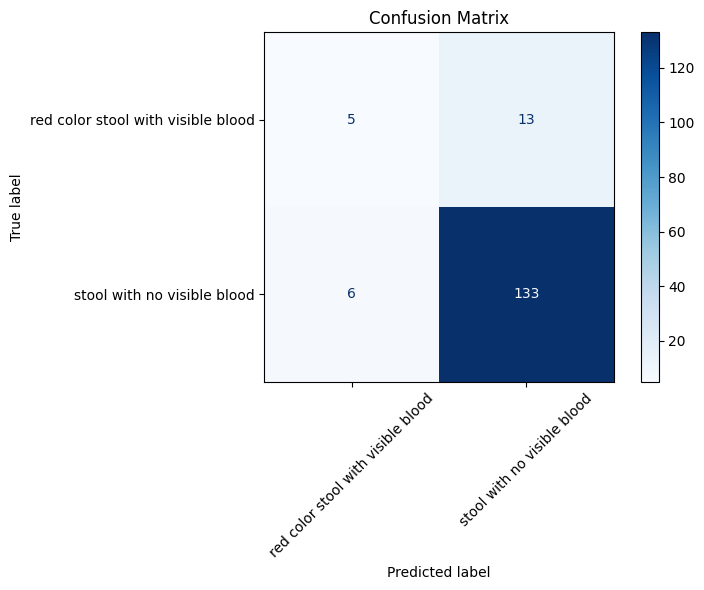

In [23]:
cm = confusion_matrix(true_labels, preds, labels=list(range(len(CLASS_NAMES))))

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=True, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [350]:
print(cm)

[[ 19   3]
 [ 27 114]]


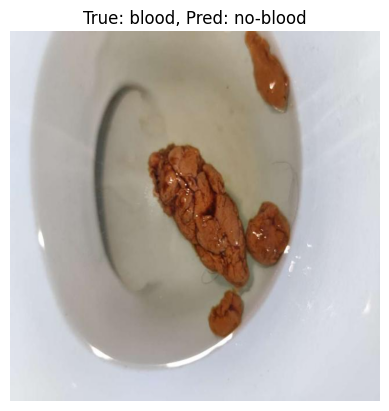

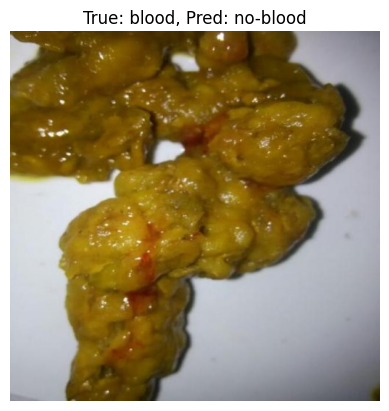

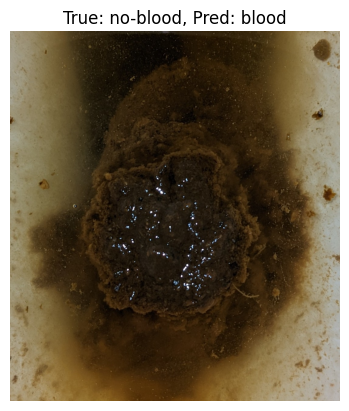

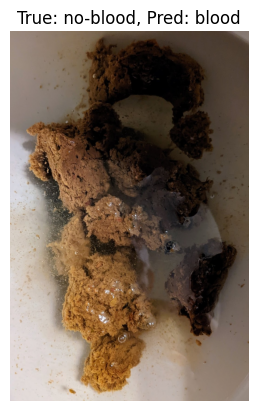

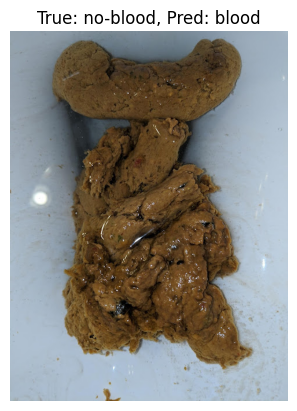

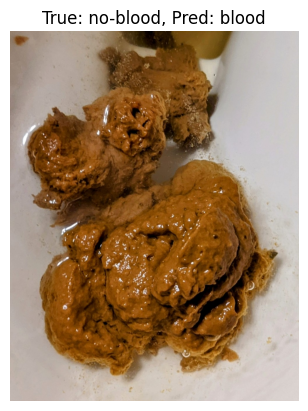

In [16]:
def show_misclassified(image_paths, preds, true_labels, max_display=6):

    classes = ['blood', 'no-blood']

    wrong = [(p, t, img) for p, t, img in zip(preds, true_labels, image_paths) if p != t]
    #print(wrong)

    if not wrong:
        print("No misclassified samples.")
        return
    for i, (pred, true, img_path) in enumerate(wrong[:max_display]):
        img = Image.open(img_path).convert("RGB")
        plt.figure()
        plt.imshow(img)
        #print(i, pred)
        plt.title(f"True: {classes[true]}, Pred: {classes[pred]}")
        plt.axis("off")
    plt.show()
show_misclassified(image_paths, preds, true_labels)